In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy import stats
from scipy.stats import shapiro, anderson, kstest, normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import sklearn as sk
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import preprocessing, svm
from sklearn.utils import class_weight
from skopt import BayesSearchCV

In [2]:
# Montar el almacenamiento de Drive y cargar el archivo Excel Bnaking crises de Harvard para posteriormente convertirlo en csv.( Un archivo csv es mas facil de trabajar)

df=pd.read_csv('C:/Users/david/Desktop/Tfg/Database/bank_crises.csv')

#Eliminar las columnas que no nos interesan, debido a la consideracion de su no relevancia o su dificil inclusion en el modelo)

delete_columns=['Banking_Crisis_Notes', 'Gold Standard', 'exch_usd_alt1', 'exch_usd_alt2', 'exch_usd_alt3', 'conversion_notes', 'national currency', 'exch_primary source code', 'exch_sources', 'Domestic_Debt_ Notes/Sources', 'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors',  'Defaults_External_Notes', '<' ]
df.drop(delete_columns, axis=1, inplace=True)

# Renombramiento de columnas para un mejor manejo

nuevos_nombres = {

'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_default', 'Inflation, Annual percentages of average consumer prices': 'inflation_annual_cpi', 'Banking Crisis ': 'Banking Crisis'
}
df = df.rename(columns=nuevos_nombres)

# Eliminacion de la primera fila, con valores nulos o valores irrelevantes como 'x'

df = df.drop(index=0)

# Cambio de tipo de dato, a un tipo que corresponda. Se decide cambiar a float para evitar problemas a la hora de aplicar imputadores

df['exch_usd'] = pd.to_numeric(df['exch_usd'], errors='coerce')
df['inflation_annual_cpi'] = pd.to_numeric(df['inflation_annual_cpi'], errors='coerce')
df['Inflation Crises'] = pd.to_numeric(df['Inflation Crises'], errors='coerce')
df['sovereign_external_debt_default'] = pd.to_numeric(df['sovereign_external_debt_default'], errors='coerce')
df['GDP_Weighted_default'] = pd.to_numeric(df['GDP_Weighted_default'], errors='coerce')
df['Case'] = df['Case'].astype(float)
df['Year'] = df['Year'].astype(float)
df['Systemic Crisis'] = df['Systemic Crisis'].astype(float)
df['Banking Crisis'] = pd.to_numeric(df['Banking Crisis'], downcast='integer')
df['exch_usd'] = df['exch_usd'].astype(float)
df['Domestic_Debt_In_Default'] = df['Domestic_Debt_In_Default'].astype(float)
df['sovereign_external_debt_default'] = df['sovereign_external_debt_default'].astype(float)
df['inflation_annual_cpi'] = df['inflation_annual_cpi'].astype(float)
df['Currency Crises'] = df['Currency Crises'].astype(float)
df['Inflation Crises'] = df['Inflation Crises'].astype(float)
df['GDP_Weighted_default'] = df['GDP_Weighted_default'].astype(float)

# Se descartan dos paises y dos anos debido a la falta de datos que presentan en la variable objetivo y las variables explicativas

nan_countries=['Ireland', 'Switzerland' ]
delete_countries = df[df['Country'].isin(nan_countries)].index

df.drop(delete_countries, axis=0, inplace=True)

years=[2015, 2016 ]
delete_years = df[df['Year'].isin(years)].index

df.drop(delete_years, axis=0, inplace = True)

# Captacion de Outliers mediante el metodo IQR con un factor k=3 para detectar outliers extremos, dado que suponemos que el problema no esta en la medicion de los datos, sino que estos outliers aportan informacion valiosa.

def cap_outliers_iqr(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Limitar los valores que exceden los límites

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

columnas_limpias = ['exch_usd', 'inflation_annual_cpi', 'GDP_Weighted_default']

df = cap_outliers_iqr(df, columnas_limpias)

# Creacion del training, validation y test set para X e y

X = df.drop('Banking Crisis', axis=1)
y = df['Banking Crisis']

print(y.isnull().sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42 )


5


In [3]:
print(df.columns)
df.shape

Index(['Case', 'CC3', 'Country', 'Year', 'Banking Crisis', 'Systemic Crisis',
       'exch_usd', 'Domestic_Debt_In_Default',
       'sovereign_external_debt_default', 'GDP_Weighted_default',
       'inflation_annual_cpi', 'Independence', 'Currency Crises',
       'Inflation Crises'],
      dtype='object')


(14620, 14)

In [4]:
# Funcion para regularizar L1

def regularize_l1(df, columns):
    df_non_null = df[columns].dropna()
    df_regularized = normalize(df_non_null, norm='l1')
    df_l1 = pd.DataFrame(df_regularized, columns=[col + '_l1' for col in columns], index=df_non_null.index)
    df = df.join(df_l1, how='left')
    return df

columns_to_regularize = ['exch_usd', 'inflation_annual_cpi', 'GDP_Weighted_default']

# Funcion para normalizar Yeo-Johnson

def transform_yeo_johnson(df, columns):
    pt = PowerTransformer(method='yeo-johnson')
    transformed_columns = [col + '_YJ' for col in columns]
    df[transformed_columns] = pt.fit_transform(df[columns])
    return df

columns_to_transform = ['inflation_annual_cpi_l1', 'exch_usd_l1', 'GDP_Weighted_default_l1']

# Funcion para aplicar One Hot Encoder

def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns)

columns_to_encode = ['Country', 'Year']

#Imputar con LightGBM

def impute_with_lightgbm(df):
    for column in df.columns:
        if df[column].isnull().any():
            df_train = df[df[column].notnull()]
            df_test = df[df[column].isnull()]

            Xdf_train = df_train.select_dtypes(include=['number'])
            ydf_train = df_train[column]
            Xdf_test = df_test.select_dtypes(include=['number'])

            # Train LightGBM model for imputation
            lgb_model = lgb.LGBMRegressor()
            lgb_model.fit(Xdf_train, ydf_train)

            # Impute missing values
            imputed_values = lgb_model.predict(Xdf_test)

            # Convert imputed values to integers if the column is of integer type
            if df[column].dtype == 'int64':
                imputed_values = np.nan_to_num(imputed_values, nan=-1).round().astype('Int64')
            df.loc[df[column].isnull(), column] = imputed_values

    return df

# MinMax Scaler

def scale_and_clean_data(df):
    scaler = MinMaxScaler()

    # Escalar las columnas especificadas
    df['exch_usd_l1_YJ_minmax'] = scaler.fit_transform(df[['exch_usd_l1_YJ']])
    df['inflation_annual_cpi_l1_YJ_minmax'] = scaler.fit_transform(df[['inflation_annual_cpi_l1_YJ']])
    df['GDP_Weighted_default_l1_YJ_minmax'] = scaler.fit_transform(df[['GDP_Weighted_default_l1_YJ']])

    # Eliminar las columnas no necesarias
    delete_columns = ['Case', 'CC3', 'GDP_Weighted_default_l1', 'exch_usd_l1', 'inflation_annual_cpi_l1',
                      'inflation_annual_cpi_l1_YJ', 'exch_usd_l1_YJ', 'GDP_Weighted_default_l1_YJ',
                      'GDP_Weighted_default', 'exch_usd', 'inflation_annual_cpi']
    df = df.drop(delete_columns, axis=1, inplace=False)

    # Sustituir valores en la columna 'Currency Crises'
    df['Currency Crises'] = df['Currency Crises'].replace(2, 1)
    df['Inflation Crises'] = pd.to_numeric(df['Inflation Crises'], errors='coerce')
    df['sovereign_external_debt_default'] = pd.to_numeric(df['sovereign_external_debt_default'], errors='coerce')
    df['Domestic_Debt_In_Default'] = pd.to_numeric(df['Domestic_Debt_In_Default'], errors='coerce')
    df['Currency Crises'] = pd.to_numeric(df['Currency Crises'], errors='coerce')
    df['Systemic Crisis'] = pd.to_numeric(df['Systemic Crisis'], errors='coerce')
    df['Systemic Crisis'] = df['Systemic Crisis'].astype(int)
    df['Domestic_Debt_In_Default'] = df['Domestic_Debt_In_Default'].astype(int)
    df['sovereign_external_debt_default'] = df['sovereign_external_debt_default'].astype(int)
    df['Currency Crises'] = df['Currency Crises'].astype(int)
    df['Inflation Crises'] = df['Inflation Crises'].astype(int)



    return df

#Preprocesado de datos

def preprocess_data(df):
    # Regularizar L1
    columns_to_regularize = ['exch_usd', 'inflation_annual_cpi', 'GDP_Weighted_default']
    df = regularize_l1(df, columns_to_regularize)

    # Normalizar Yeo-Johnson
    columns_to_transform = ['inflation_annual_cpi_l1', 'exch_usd_l1', 'GDP_Weighted_default_l1']
    df = transform_yeo_johnson(df, columns_to_transform)

    # Aplicar One Hot Encoding
    columns_to_encode = ['Country', 'Year']
    df = one_hot_encode(df, columns_to_encode)

    # Imputar valores faltantes con LightGBM
    df = impute_with_lightgbm(df)

    # Escalar y limpiar datos
    df = scale_and_clean_data(df)

    # Describir el DataFrame resultante
    print(df.describe())

    return df



In [5]:
#Preprocesamiento de los conjuntos

df = X_train
X_train_prepared = preprocess_data(df)

df = X_test
X_test_prepared = preprocess_data(df)

df= X_val
X_val_prepared = preprocess_data(df)


y_train_prepared = y_train.fillna(0)
y_test_prepared = y_test.fillna(0)
y_val = y_val.fillna(0)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 9343, number of used features: 15
[LightGBM] [Info] Start training from score 0.037996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [6]:
# Tecnica de Oversampling aplicando SMOTE debido al poco porcentaje de la clase 1 en el dataset

smote = SMOTE(random_state=42)

X_train_prepared, y_train_prepared = smote.fit_resample(X_train_prepared, y_train_prepared)

print('Resampled dataset shape %s' % Counter(y_train_prepared))


Resampled dataset shape Counter({0.0: 8830, 1.0: 8830})


Dataset desbalanceado en las clases. Cemos en la trampa del Accuracy. Hacemos SMOTE Proporcion 2:! siendo 2 0 y 1 1 la minoritaria

In [8]:
# Definir la cuadrícula de parámetros
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 300, 400, 500]},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [100, 200, 300, 400, 500]},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'max_iter': [100, 200, 300, 400, 500], 'l1_ratio': [0.15, 0.5, 0.85]},
    {'penalty': ['none'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'max_iter': [100, 200, 300, 400, 500]}
]

# Crear el modelo de regresión logística
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# G-Mean
def geometric_mean_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate Sensitivity and Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Calculate G-Mean
    g_mean = np.sqrt(sensitivity * specificity)
    return g_mean

g_mean_scorer = make_scorer(geometric_mean_score, greater_is_better=True)

precision_class_1 = make_scorer(precision_score, average='binary', label=[1])
recall_class_1 = make_scorer(recall_score, average='binary', labels=[1])
f1_class_1 = make_scorer(f1_score, average='binary', labels=[1])

# Configurar GridSearchCV con múltiples métricas
scoring = {'recall_class_1': recall_class_1, 'f1_class_1': f1_class_1, 'precision_class_1': precision_class_1}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42), 
                           scoring=scoring, refit='f1_class_1', n_jobs=-1, verbose=2)

# Ajustar el modelo
grid_search.fit(X_train_prepared, y_train_prepared)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation recall for class 1: ", grid_search.cv_results_['mean_test_recall_class_1'][grid_search.best_index_])
print("Best cross-validation F1-score for class 1: ", grid_search.cv_results_['mean_test_f1_class_1'][grid_search.best_index_])
print("Best cross-validation precision for class 1:", grid_search.cv_results_['mean_test_precision_class_1'][grid_search.best_index_])

best_model = grid_search.best_estimator_
best_model.fit(X_train_prepared, y_train_prepared)

Fitting 10 folds for each of 350 candidates, totalling 3500 fits


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1000 fits failed out of a total of 3500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
401 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ba

Best parameters found:  {'C': 10, 'l1_ratio': 0.15, 'max_iter': 200, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation recall for class 1:  0.9780891825199387
Best cross-validation F1-score for class 1:  0.9859347738866481
Best cross-validation precision for class 1: nan


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.15, max_iter=200,
                   penalty='elasticnet', random_state=42, solver='saga')

c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

[[8777   53]
 [ 193 8637]]
[0.98584371 0.98640997 0.98471121 0.98414496 0.98527746 0.98754247
 0.98810872 0.98357871 0.99093998 0.98414496]
Exactitud: 0.986
Precisión: 0.986
Sensibilidad: 0.986
F1-score: 0.986
Matriz de confusión:
 [[8777   53]
 [ 193 8637]]
Tabla de métricas:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      8830
         1.0       0.99      0.98      0.99      8830

    accuracy                           0.99     17660
   macro avg       0.99      0.99      0.99     17660
weighted avg       0.99      0.99      0.99     17660

Accuracy:   0.9861 +/- 0.0022


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


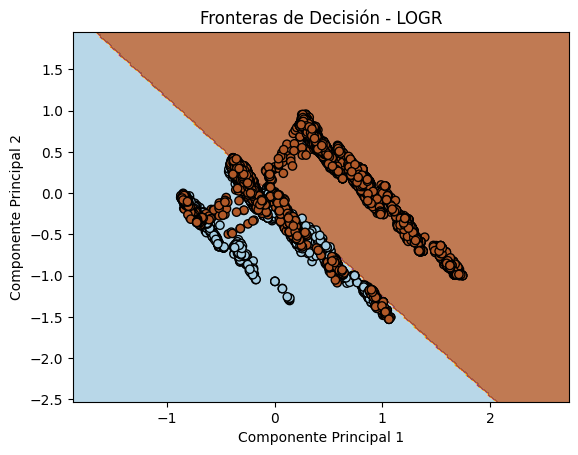

Exactitud en test:  97.4008 %
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2763
         1.0       0.86      0.63      0.73       161

    accuracy                           0.97      2924
   macro avg       0.92      0.81      0.86      2924
weighted avg       0.97      0.97      0.97      2924

[[2747   16]
 [  60  101]]
                                     0                       1
0                      Systemic Crisis     [7.037208647891868]
1             Domestic_Debt_In_Default    [0.1336740374231206]
2      sovereign_external_debt_default   [-0.5052838762397704]
3                         Independence    [0.3762271636106964]
4                      Currency Crises  [-0.03167203982405418]
..                                 ...                     ...
287                        Year_2013.0     [6.280038384802894]
288                        Year_2014.0     [5.977088775208766]
289              exch_usd_l1_YJ_minmax   [0.21606

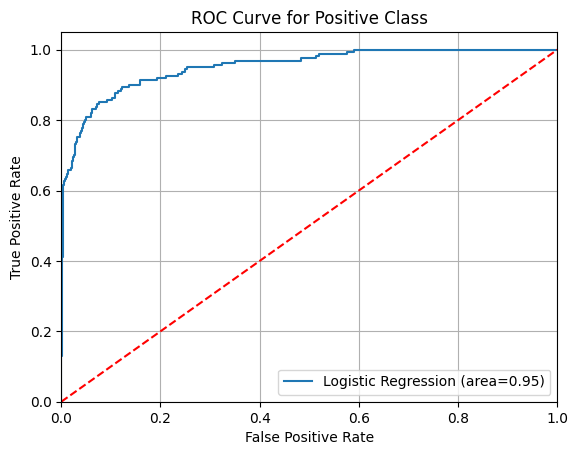

Valor de AUC:  0.9519740672551888
G-Mean on the test set:  0.7897445474381419


In [11]:
# Regresion Logistica

best_params = grid_search.best_params_

Regresion_Logistica = {
    'LOGR': LogisticRegression(
        penalty=best_params['penalty'],
        l1_ratio=best_params['l1_ratio'],
        C=best_params['C'],
        solver=best_params['solver'],
        max_iter=best_params['max_iter'],
        class_weight='balanced',
        random_state=42
    )
}

# Uso de cross_val_predict y score para ver como funciona el modelo con test generados internamente por la funcion(sin involucar el test real, perdiendo asi capacidad de evaluar la generalizacion del modelo)

y_pred = {}
for nombre, alg in Regresion_Logistica.items():
    y_pred[nombre] = cross_val_predict(alg, X_train_prepared, y_train_prepared, cv=KFold(n_splits=10, shuffle=True, random_state=42))
    results = cross_val_score(alg, X_train_prepared, y_train_prepared, cv = KFold(n_splits=10, shuffle=True, random_state=42))
    print(metrics.confusion_matrix(y_train_prepared, y_pred[nombre]))
    print(results)
    print("Exactitud: %.3f" % (metrics.accuracy_score(y_train_prepared, y_pred[nombre]))) # accuracy
    print("Precisión: %.3f" % (metrics.precision_score(y_train_prepared, y_pred[nombre], average="weighted"))) # precision
    print("Sensibilidad: %.3f" % (metrics.recall_score(y_train_prepared, y_pred[nombre], average="weighted"))) # sensibilidad
    print("F1-score: %.3f" % (metrics.f1_score(y_train_prepared, y_pred[nombre], average="weighted"))) # F-score
    print("Matriz de confusión:\n", metrics.confusion_matrix(y_train_prepared, y_pred[nombre]))
    print("Tabla de métricas:\n", metrics.classification_report(y_train_prepared, y_pred[nombre]))
    print("Accuracy:   %0.4f +/- %0.4f" % (results.mean(), results.std()))

# Entrenamiento del modelo definitivo

model = Regresion_Logistica['LOGR'].fit(X_train_prepared, y_train_prepared)

# Visualización de las fronteras de decisión

def mapa_modelo_clasif_2d(X_train_prepared, y_train_prepared, model, results, nombre):

    """
    Visualiza las fronteras de decisión de un modelo de clasificación en 2D.

    Args:
        X_train_prepared: Datos de entrenamiento.
        y_train_prepared: Etiquetas de entrenamiento.
        model: Modelo de clasificación entrenado.
        results: Resultados de la validación cruzada.
        nombre: Nombre del modelo.
    """
    # Reducimos la dimensionalidad a 2 usando PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_train_prepared)

    # Crea una malla de puntos para visualizar las fronteras
    h = .02  # Tamaño de paso en la malla
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predice las etiquetas para cada punto en la malla
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Grafica las fronteras de decisión
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Grafica los puntos de entrenamiento
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train_prepared, cmap=plt.cm.Paired, edgecolor='k')

    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(f"Fronteras de Decisión - {nombre}")
    plt.show()

# Llamamos a la función modificada
mapa_modelo_clasif_2d(X_train_prepared, y_train_prepared, model, results, "LOGR")

# Prediccion del conjunto de test para ver que tan bien generaliza

y_pred_test = model.predict(X_test_prepared)

# Evaluacion:

test_results = model.score(X_test_prepared, y_test_prepared)

print('Exactitud en test: ', np.round(test_results*100,4), '%')
print(metrics.classification_report(y_test_prepared, y_pred_test)) # Aplicar el método de classification_report()
print(metrics.confusion_matrix(y_test_prepared, y_pred_test)) # Extraer la matriz de confusión
print(pd.DataFrame(zip(X_test_prepared.columns, np.transpose(model.coef_)))) # Extraer los coeficientes del modelo

# Curva ROC

y_proba_test = model.predict_proba(X_test_prepared)

# Binarize the true labels
y_test_bin = preprocessing.label_binarize(y_test_prepared, classes=[0, 1, 2])

# Calculate the AUC score for the positive class
auc = metrics.roc_auc_score(y_test_bin, y_proba_test, multi_class='ovr')

# Plot the ROC curve for the positive class
fpr, tpr, thresholds = metrics.roc_curve(y_test_bin[:, 1], y_proba_test[:, 1])
plt.plot(fpr, tpr, label= 'Logistic Regression (area=%0.2f)' % auc )
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Positive Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print('Valor de AUC: ', auc)

# G-Mean on the test set

g_mean_test = geometric_mean_score(y_test_prepared, y_pred_test)
print("G-Mean on the test set: ", g_mean_test)

In [14]:
# Definir la cuadrícula de parámetros
param_grid = [
   
    {'C': [0.01, 1, 10], 'kernel': ['poly'], 'degree': [2, 3, 4], 'max_iter': [1000, 2000]},
]

# Crear el modelo SVM
svm_model = svm.SVC(probability=True, random_state=42)

# G-Mean
def geometric_mean_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate Sensitivity and Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Calculate G-Mean
    g_mean = np.sqrt(sensitivity * specificity)
    return g_mean

g_mean_scorer = make_scorer(geometric_mean_score, greater_is_better=True)

precision_class_1 = make_scorer(precision_score, average='binary', label=[1])
recall_class_1 = make_scorer(recall_score, average='binary', labels=[1])
f1_class_1 = make_scorer(f1_score, average='binary', labels=[1])

# Configurar GridSearchCV con múltiples métricas
scoring = {'recall_class_1': recall_class_1, 'f1_class_1': f1_class_1, 'precision_class_1': precision_class_1, 'g_mean_scorer': g_mean_scorer}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                           cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring=scoring, refit='f1_class_1', n_jobs=-1, verbose=2)

# Ajustar el modelo
grid_search.fit(X_train_prepared, y_train_prepared)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation recall for class 1: ", grid_search.cv_results_['mean_test_recall_class_1'][grid_search.best_index_])
print("Best cross-validation F1-score for class 1: ", grid_search.cv_results_['mean_test_f1_class_1'][grid_search.best_index_])
print("Best cross-validation precision for class 1:", grid_search.cv_results_['mean_test_precision_class_1'][grid_search.best_index_])

best_model = grid_search.best_estimator_
best_model.fit(X_train_prepared, y_train_prepared)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters found:  {'C': 1, 'degree': 4, 'kernel': 'poly', 'max_iter': 1000}
Best cross-validation recall for class 1:  0.9844224183801179
Best cross-validation F1-score for class 1:  0.9906236588787554
Best cross-validation precision for class 1: nan


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=1, degree=4, kernel='poly', max_iter=1000, probability=True,
    random_state=42)

Best parameters found:  {'C': 10, 'degree': 3, 'kernel': 'poly', 'max_iter': 1000}
Best cross-validation recall for class 1:  0.9852664445866408
Best cross-validation F1-score for class 1:  0.9909410706916242
Best cross-validation precision for class 1: nan

c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

[[8803   27]
 [ 137 8693]]
[0.99093998 0.99207248 0.99037373 0.98527746 0.98867497 0.98980747
 0.99263873 0.99037373 0.99490374 0.99207248]
Exactitud: 0.991
Precisión: 0.991
Sensibilidad: 0.991
F1-score: 0.991
Matriz de confusión:
 [[8803   27]
 [ 137 8693]]
Tabla de métricas:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8830
         1.0       1.00      0.98      0.99      8830

    accuracy                           0.99     17660
   macro avg       0.99      0.99      0.99     17660
weighted avg       0.99      0.99      0.99     17660

Accuracy:   0.9907 +/- 0.0024


c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


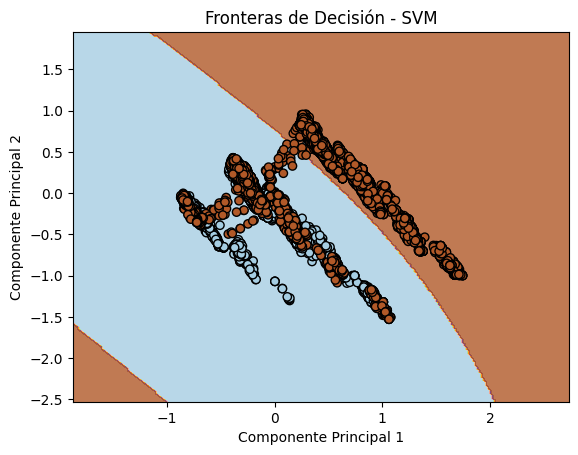

Exactitud en test:  97.5718 %
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2763
         1.0       0.92      0.61      0.73       161

    accuracy                           0.98      2924
   macro avg       0.95      0.80      0.86      2924
weighted avg       0.97      0.98      0.97      2924

[[2755    8]
 [  63   98]]


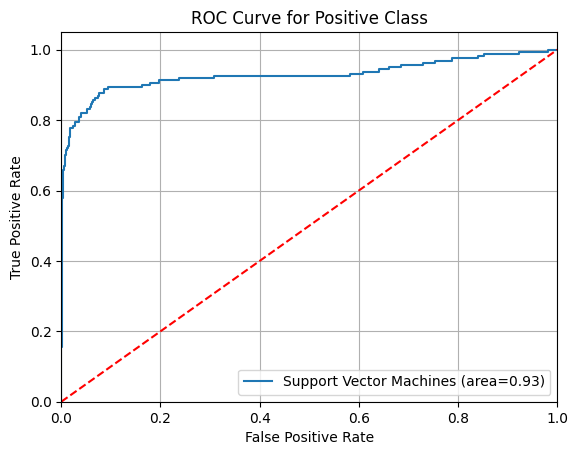

Valor de AUC:  0.9284084497227112
G-Mean on the test set:  0.7790591971240983


In [16]:
# Support Vector Machines

SupportVM = {'SVM': best_model}

y_pred = {}
for nombre, alg in SupportVM.items():
    y_pred[nombre] = cross_val_predict(alg, X_train_prepared, y_train_prepared, cv=KFold(n_splits=10, shuffle=True, random_state=42))
    results = cross_val_score(alg, X_train_prepared, y_train_prepared, cv = KFold(n_splits=10, shuffle=True, random_state=42))
    print(metrics.confusion_matrix(y_train_prepared, y_pred[nombre]))
    print(results)
    print("Exactitud: %.3f" % (metrics.accuracy_score(y_train_prepared, y_pred[nombre]))) # accuracy
    print("Precisión: %.3f" % (metrics.precision_score(y_train_prepared, y_pred[nombre], average="weighted"))) # precision
    print("Sensibilidad: %.3f" % (metrics.recall_score(y_train_prepared, y_pred[nombre], average="weighted"))) # sensibilidad
    print("F1-score: %.3f" % (metrics.f1_score(y_train_prepared, y_pred[nombre], average="weighted"))) # F-score
    print("Matriz de confusión:\n", metrics.confusion_matrix(y_train_prepared, y_pred[nombre]))
    print("Tabla de métricas:\n", metrics.classification_report(y_train_prepared, y_pred[nombre]))
    print("Accuracy:   %0.4f +/- %0.4f" % (results.mean(), results.std()))

# Entrenamiento del modelo definitivo

model = SupportVM['SVM'].fit(X_train_prepared, y_train_prepared)

# Visualización de las fronteras de decisión

def mapa_modelo_clasif_2d(X_train_prepared, y_train_prepared, model, results, nombre):
    """
    Visualiza las fronteras de decisión de un modelo de clasificación en 2D.

    Args:
        X_train_prepared: Datos de entrenamiento.
        y_train_prepared: Etiquetas de entrenamiento.
        model: Modelo de clasificación entrenado.
        results: Resultados de la validación cruzada.
        nombre: Nombre del modelo.
    """
    # Reducimos la dimensionalidad a 2 usando PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_train_prepared)

    # Crea una malla de puntos para visualizar las fronteras
    h = .02  # Tamaño de paso en la malla
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predice las etiquetas para cada punto en la malla
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Grafica las fronteras de decisión
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Grafica los puntos de entrenamiento
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train_prepared, cmap=plt.cm.Paired, edgecolor='k')

    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(f"Fronteras de Decisión - {nombre}")
    plt.show()

# Llamamos a la función modificada
mapa_modelo_clasif_2d(X_train_prepared, y_train_prepared, model, results, "SVM")
# Prediccion del conjunto de test

y_pred_test = model.predict(X_test_prepared)

# Evaluacion:

test_results = model.score(X_test_prepared, y_test_prepared)

print('Exactitud en test: ', np.round(test_results*100,4), '%')
print(metrics.classification_report(y_test_prepared, y_pred_test)) # Aplicar el método de classification_report()
print(metrics.confusion_matrix(y_test_prepared, y_pred_test)) # Extraer la matriz de confusión

# Curva ROC

y_proba_test = model.predict_proba(X_test_prepared)

# Binarize the true labels
y_test_bin = preprocessing.label_binarize(y_test_prepared, classes=[0, 1, 2])

# Calculate the AUC score for the positive class
auc = metrics.roc_auc_score(y_test_bin, y_proba_test, multi_class='ovr')

# Plot the ROC curve for the positive class
fpr, tpr, thresholds = metrics.roc_curve(y_test_bin[:, 1], y_proba_test[:, 1])
plt.plot(fpr, tpr, label= 'Support Vector Machines (area=%0.2f)' % auc )
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Positive Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print('Valor de AUC: ', auc)

# G-Mean on the test set

g_mean_test = geometric_mean_score(y_test_prepared, y_pred_test)
print("G-Mean on the test set: ", g_mean_test)

In [17]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation recall for class 1: ", grid_search.cv_results_['mean_test_recall_class_1'][grid_search.best_index_])
print("Best cross-validation F1-score for class 1: ", grid_search.cv_results_['mean_test_f1_class_1'][grid_search.best_index_])
print("Best cross-validation precision for class 1:", grid_search.cv_results_['mean_test_precision_class_1'][grid_search.best_index_])

Best parameters found:  {'C': 1, 'degree': 4, 'kernel': 'poly', 'max_iter': 1000}
Best cross-validation recall for class 1:  0.9844224183801179
Best cross-validation F1-score for class 1:  0.9906236588787554
Best cross-validation precision for class 1: nan


Ite=1000


Exactitud en test:  97.777 %
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2763
         1.0       0.93      0.65      0.76       161

    accuracy                           0.98      2924
   macro avg       0.95      0.82      0.88      2924
weighted avg       0.98      0.98      0.98      2924

[[2755    8]
 [  57  104]]


In [ ]:
"""
Tocar la forma en la que hago el split
Mejorar el imputador
Aplicar GridSearch en los modelos para mejorar sus hiperparametros
https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/ esto es para el svm
https://www.researchgate.net/publication/340978368_Machine_Learning_with_Oversampling_and_Undersampling_Techniques_Overview_Study_and_Experimental_Results Oversampling y undersampling

https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regressionayuda para la regresion logistica
"""


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [8]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(torch.cuda.is_available())

Using device: cpu
Num GPUs Available:  0
False


In [4]:
import torch
print(torch.version.cuda)  # This should print the CUDA version PyTorch was built with.
print(torch.cuda.is_available()) 

None
False


In [5]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Running on: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Example operation on the GPU
x = torch.rand(10000, 10000).to(device)
y = x * x
print(y)

Running on CPU
tensor([[1.5163e-01, 2.6723e-02, 5.4863e-01,  ..., 1.7589e-01, 1.6989e-02,
         6.9062e-02],
        [2.5622e-01, 1.5123e-02, 5.5690e-01,  ..., 5.9254e-01, 4.4764e-02,
         2.2732e-03],
        [3.2816e-04, 9.0973e-01, 7.5841e-01,  ..., 5.3433e-01, 9.4584e-02,
         4.5173e-01],
        ...,
        [3.5787e-01, 4.9643e-01, 9.4934e-01,  ..., 4.7331e-01, 1.0792e-01,
         1.7529e-01],
        [1.8628e-01, 9.2113e-03, 6.0362e-01,  ..., 2.7537e-01, 5.6856e-02,
         6.0731e-01],
        [9.7548e-01, 5.0643e-02, 1.4891e-02,  ..., 2.3993e-01, 1.1329e-03,
         3.4285e-01]])


In [18]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# Define the function to create the model
def create_perceptron_model():
    model = keras.Sequential([
        keras.Input(shape=X_train_prepared.shape[1:]),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.FalseNegatives(name="fn"),
            keras.metrics.FalsePositives(name="fp"),
            keras.metrics.TrueNegatives(name="tn"),
            keras.metrics.TruePositives(name="tp"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ]
    )
    return model

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_prepared), y=y_train_prepared)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [keras.callbacks.ModelCheckpoint("Banking_Crises_at_epoch{epoch}.keras"), early_stopping, tensorboard_callback]

# Train the final model
final_model = create_perceptron_model()
history = final_model.fit(
    X_train_prepared, y_train_prepared,
    epochs=1000,
    validation_split=0.1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Evaluate the model on the test set
y_pred_test = (final_model.predict(X_test_prepared) > 0.5).astype("int32")
test_results = final_model.evaluate(X_test_prepared, y_test_prepared, verbose=0)[1]

print('Exactitud en test: ', np.round(test_results * 100, 4), '%')
print("Classification Report:\n", metrics.classification_report(y_test_prepared, y_pred_test))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test_prepared, y_pred_test))

# ROC Curve
y_proba_test = final_model.predict(X_test_prepared)
auc = metrics.roc_auc_score(y_test_prepared, y_proba_test)

fpr, tpr, _ = metrics.roc_curve(y_test_prepared, y_proba_test)
plt.plot(fpr, tpr, label='Perceptron (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Positive Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# G-Mean on the test set
g_mean_test = geometric_mean_score(y_test_prepared, y_pred_test)
print("G-Mean on the test set: ", g_mean_test)

In [ ]:
# Define the function to create the model
def create_perceptron_model():
    model = keras.Sequential([
        keras.Input(shape=X_train_prepared.shape[1:]),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.FalseNegatives(name="fn"),
            keras.metrics.FalsePositives(name="fp"),
            keras.metrics.TrueNegatives(name="tn"),
            keras.metrics.TruePositives(name="tp"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ]
    )
    return model

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_prepared), y=y_train_prepared)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [keras.callbacks.ModelCheckpoint("Banking_Crises_at_epoch{epoch}.keras"), early_stopping, tensorboard_callback]

# Train the final model
final_model = create_perceptron_model()
history = final_model.fit(
    X_train_prepared, y_train_prepared,
    epochs=1000,
    validation_split=0.1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Evaluate the model on the test set
y_pred_test = (final_model.predict(X_test_prepared) > 0.5).astype("int32")
test_results = final_model.evaluate(X_test_prepared, y_test_prepared, verbose=0)[1]

print('Exactitud en test: ', np.round(test_results * 100, 4), '%')
print("Classification Report:\n", metrics.classification_report(y_test_prepared, y_pred_test))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test_prepared, y_pred_test))

# ROC Curve
y_proba_test = final_model.predict(X_test_prepared)
auc = metrics.roc_auc_score(y_test_prepared, y_proba_test)

fpr, tpr, _ = metrics.roc_curve(y_test_prepared, y_proba_test)
plt.plot(fpr, tpr, label='Perceptron (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Positive Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# G-Mean on the test set
g_mean_test = geometric_mean_score(y_test_prepared, y_pred_test)
print("G-Mean on the test set: ", g_mean_test)